# Bank Personal Loan Modelling with two classification models

## 1- Introduction

In this project, we use data from bank loans to customers, and I have used **logistic classification and random forest models** to predict whether a loan will be granted to a customer or not. The address of the data used is as follows:  
https://www.kaggle.com/code/pritech/bank-personal-loan-modelling/input

In [1]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

## 2- loading data and doing some explorations

In [2]:
data=pd.read_csv ('Bank_Personal_Loan_Modelling.csv', header=0, index_col='ID')
data.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Since the dependent variable is 'Personal Loan', we change the corresponding column to the end of the table.

In [5]:
cols = list(data.columns.values) 
cols.pop(cols.index('Personal Loan')) 
data = data[cols+['Personal Loan']]
data.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,1,0,0,0,0
2,45,19,34,90089,3,1.5,1,0,1,0,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,1,0


### 2-1- ZIP Code Variable  

Some people have omitted the variable "ZIP Code", but I think that the person's location can influence whether or not the bank will pay the loan. Therefore, I will examine this variable here.  
One of the widely used methods to check the explanatory power of the independent variable on the dependent variable is to use **the Information Value (IV) method**. Information Value shows how much information the original independent variable brings with respect to explaining the dependent variable.

First, we need to calculate the number of granted and ungranted loans based on the zip code variable.

In [6]:
dftemp=pd.concat([data['ZIP Code'], data['Personal Loan']], axis=1)

In [7]:
dftemp= pd.concat([dftemp.groupby(dftemp.columns.values[0], as_index=False)[dftemp.columns.values[1]].count(),\
                   dftemp.groupby(dftemp.columns.values[0], as_index=False)[dftemp.columns.values[1]].mean()],axis=1)
dftemp=dftemp.iloc[:,[0,1,3]]
dftemp.columns=[dftemp.columns.values[0], 'n_obs', 'prop']
dftemp

,ZIP Code,n_obs,prop
0,9307,1,0.0
1,90005,5,0.0
2,90007,6,0.0
3,90009,8,0.0
4,90011,3,0.0
...,...,...,...
462,96091,4,0.0
463,96094,2,0.0
464,96145,1,0.0
465,96150,4,0.0


The two concepts - **weight of evidence (WOE) and information value (IV)** have been in existence in credit scoring world for more than 4-5 decades. They have been used as a benchmark to screen variables in the credit risk modeling projects such as probability of default. 
**The weight of evidence** tells the predictive power of an independent variable in relation to the dependent variable. It is calculated by taking the natural logarithm (log to base e) of division of % of non-events and % of events.  
**WOE = In(% of non-events ➗ % of events)**
**Steps of Calculating WOE**
For a continuous variable, split data into 10 parts (or lesser depending on the distribution).
Calculate the number of events and non-events in each group (bin)
Calculate the % of events and % of non-events in each group.
Calculate WOE by taking natural log of division of % of non-events and % of events  
**Information value** is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance. The IV is calculated using the following formula:
**IV = ∑ (% of non-events - % of events) * WOE**
If the IV statistic is:
Less than 0.02, then the predictor is not useful for modeling (separating the Goods from the Bads)
0.02 to 0.1, then the predictor has only a weak relationship to the Goods/Bads odds ratio
0.1 to 0.3, then the predictor has a medium strength relationship to the Goods/Bads odds ratio
0.3 to 0.5, then the predictor has a strong relationship to the Goods/Bads odds ratio.  
Larger than 0.5, suspicious relationship (Check once)  

Source: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html  
I perform the necessary calculations below.

In [8]:
#Calculate the ratio of the number of observations to the total number of observations
dftemp['prop_n_obs']=dftemp['n_obs']/dftemp['n_obs'].sum()
#Calculation of the number of loans granted (y=1) and not granted (y=0)
dftemp['n_one']=dftemp['prop']*dftemp['n_obs']
dftemp['n_zero']=(1-dftemp['prop'])*dftemp['n_obs']
#Calculation of granted and ungranted loans of each class to total borrowers or total ungranted loans of that class
dftemp['prop_n_one']=dftemp['n_one']/dftemp['n_one'].sum()
dftemp['prop_n_zero']=dftemp['n_zero']/dftemp['n_zero'].sum()
#Calculating Weight of Evidence (WoE)
for index, row in dftemp.iterrows():
    if dftemp.loc[index,'prop_n_one']!=0:
        dftemp.loc[index,'WoE']=np.log(dftemp.loc[index,'prop_n_one']/dftemp.loc[index,'prop_n_zero'])
    else:
        dftemp.loc[index,'WoE']=0
#Sort WoE and reset the index
dftemp=dftemp.sort_values (by='WoE')
dftemp=dftemp.reset_index (drop=True)
#calculating Information Value (IV)
dftemp['IV']=(dftemp['prop_n_one']-dftemp['prop_n_zero'])*dftemp['WoE']
dftemp['IV']=dftemp['IV'].sum()
pd.options.display.max_rows=None
dftemp

,ZIP Code,n_obs,prop,prop_n_obs,n_one,n_zero,prop_n_one,prop_n_zero,WoE,IV
0,90024,50,0.020000,0.0100,1.0,49.0,0.002083,0.010841,-1.649339,0.467182
1,94608,34,0.029412,0.0068,1.0,33.0,0.002083,0.007301,-1.254026,0.467182
2,91320,53,0.037736,0.0106,2.0,51.0,0.004167,0.011283,-0.996197,0.467182
3,95819,26,0.038462,0.0052,1.0,25.0,0.002083,0.005531,-0.976395,0.467182
4,94105,25,0.040000,0.0050,1.0,24.0,0.002083,0.005310,-0.935573,0.467182
5,93117,24,0.041667,0.0048,1.0,23.0,0.002083,0.005088,-0.893013,0.467182
6,94080,23,0.043478,0.0046,1.0,22.0,0.002083,0.004867,-0.848561,0.467182
7,95521,23,0.043478,0.0046,1.0,22.0,0.002083,0.004867,-0.848561,0.467182
8,94110,21,0.047619,0.0042,1.0,20.0,0.002083,0.004425,-0.753251,0.467182
9,90034,20,0.050000,0.0040,1.0,19.0,0.002083,0.004204,-0.701958,0.467182


Based on the obtained IV, we can say that the Zip Code variable has a high predictive power regarding the dependent variable (In general, IV between 0.3 and 0.5 means high predictive power), so we keep this variable in our model.

Now I visualise the categories of the independent variable (Zip code) baased on the value of their WoE.

Text(0, 0.5, 'Weight of Evidence')

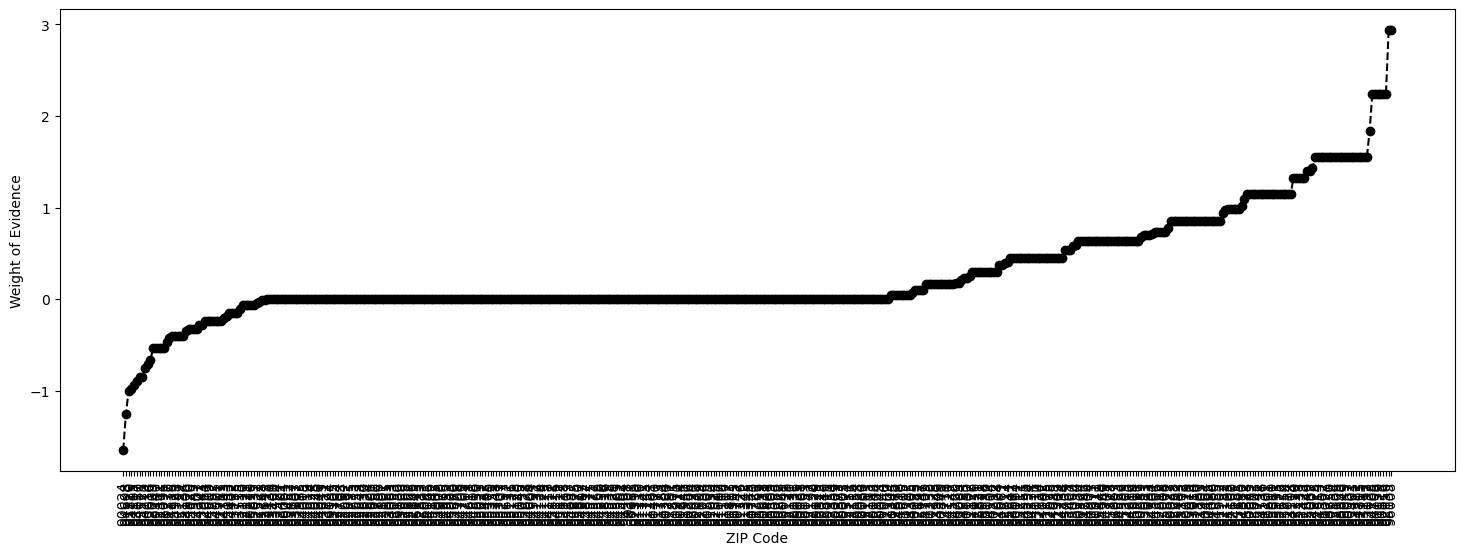

In [9]:
x=np.array(dftemp.iloc[:,0].apply(str))
y=dftemp['WoE']
plt. figure (figsize=(18,6))
plt. plot (x,y,marker='o',linestyle='--', color='k')
plt.xticks(x, rotation='vertical')
plt.xlabel (dftemp.columns[0])
plt.ylabel ('Weight of Evidence')

In [10]:
dftemp ['WoE'].nunique()

69

Now I want to have the values of WoE in the primary table.

In [11]:
#calculate unique WoE values by Zip Code in dftemp
woe_dict=dftemp.groupby ('ZIP Code')['WoE'].unique().to_dict()
#merge the main table with dftemp on Zip Code
df_merge= data.merge (dftemp, on='ZIP Code', how='left')
#create new column 'WoE merged' in the main table by mapping WOE values from woe_dict
df_merge ['WoE_merged']=df_merge['WoE'].fillna(df_merge['ZIP Code'].map(woe_dict).apply (lambda x: x[0] if len(x)==1 else None))
#Drop columns we don't need anymore and remove duplicates
df_merge.drop (['WoE'], axis=1, inplace=True)
df_merge.drop (df_merge.iloc[:,13:21], axis=1, inplace=True)
df_merge.drop_duplicates (inplace=True)
pd.options.display.max_columns=None
df_merge. head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan,WoE_merged
0,25,1,49,91107,4,1.6,1,0,1,0,0,0,0,0.250051
1,45,19,34,90089,3,1.5,1,0,1,0,0,0,0,0.684337
2,39,15,11,94720,1,1.0,1,0,0,0,0,0,0,0.176285
3,35,9,100,94112,1,2.7,2,0,0,0,0,0,0,0.000000
4,35,8,45,91330,4,1.0,2,0,0,0,0,1,0,-0.420107


Here, we convert zip codes with the same WoE values into a new and similar zip code. In fact, we want to reduce the number of zip code variable categories.

In [12]:
#group the data by WoE and get the group indices
group_indices=df_merge.groupby('WoE_merged').groups
#Creating a mapping from WoE values to special zip codes
woe_to_code={}
special_zip_code=10000
for woe, indices in group_indices.items():
    woe_to_code[woe]=special_zip_code
    special_zip_code+=1
#map the zip codes to the special zip codes using the mapping
df_merge['special_zip_code']= df_merge['WoE_merged'].map(woe_to_code)
df_merge.drop (['ZIP Code', 'WoE_merged'], axis=1, inplace=True)
#Changing place of the special_zip_code column
temp_cols=df_merge.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
df_merge=df_merge[new_cols]
df_merge.rename(columns={"special_zip_code": "Zip Code"}, inplace=True)
df_merge. head()

,Zip Code,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,10036,25,1,49,4,1.6,1,0,1,0,0,0,0
1,10047,45,19,34,3,1.5,1,0,1,0,0,0,0
2,10032,39,15,11,1,1.0,1,0,0,0,0,0,0
3,10026,35,9,100,1,2.7,2,0,0,0,0,0,0
4,10012,35,8,45,4,1.0,2,0,0,0,0,1,0


In [13]:
df_merge['Zip Code'].nunique()

69

Here we can reduce the number of zip code variable categories by further analyzing the values of WoE, but I am satisfied with this number of categories.

### 2-2- Exploring dependent variable 

In [14]:
df_merge['Personal Loan'].value_counts()/df_merge['Personal Loan'].count()

0    0.904
1    0.096
Name: Personal Loan, dtype: float64

We can see that the ratio of positive to negative examples is very **skewed**. Loans have been granted to less than 10% of people. 

### 2-3- Exploring categorical variables 

In our data set we have **5 numerical variables**: Age, Experience, Income, CCAvg and Mortgage  
Other variables are **categorical**: ZIP Code, Family, Education, CreditCard (binary), Securities Account (binary), CD Account (binary) and Online (binary).  
Our **binary dependent variable**: Personal Loan

For categorical variables, the data type is numerical, so we change it to **'category'**.

In [16]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zip Code            5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Securities Account  5000 non-null   int64  
 9   CD Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
 12  Personal Loan       5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


In [17]:
categoricals=df_merge.loc[:, ['Zip Code', 'Family', 'Education', 'CreditCard', 'Securities Account',\
                   'CD Account', 'Online', 'Personal Loan']]
categoricals

,Zip Code,Family,Education,CreditCard,Securities Account,CD Account,Online,Personal Loan
0,10036,4,1,0,1,0,0,0
1,10047,3,1,0,1,0,0,0
2,10032,1,1,0,0,0,0,0
3,10026,1,2,0,0,0,0,0
4,10012,4,2,1,0,0,0,0
5,10013,4,2,0,0,0,1,0
6,10017,2,2,0,0,0,1,0
7,10016,1,3,1,0,0,0,0
8,10047,3,2,0,0,0,1,0
9,10048,1,3,0,0,0,0,1


In [18]:
for column in categoricals:
    categoricals[column]=categoricals[column].astype ('category')
categoricals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Zip Code            5000 non-null   category
 1   Family              5000 non-null   category
 2   Education           5000 non-null   category
 3   CreditCard          5000 non-null   category
 4   Securities Account  5000 non-null   category
 5   CD Account          5000 non-null   category
 6   Online              5000 non-null   category
 7   Personal Loan       5000 non-null   category
dtypes: category(8)
memory usage: 81.7 KB


In [19]:
for column in categoricals:
    df_merge[column]=categoricals[column]
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Zip Code            5000 non-null   category
 1   Age                 5000 non-null   int64   
 2   Experience          5000 non-null   int64   
 3   Income              5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Securities Account  5000 non-null   category
 9   CD Account          5000 non-null   category
 10  Online              5000 non-null   category
 11  CreditCard          5000 non-null   category
 12  Personal Loan       5000 non-null   category
dtypes: category(8), float64(1), int64(4)
memory usage: 277.0 KB


### 2-4- Exploring numerical variables 

Now let's examine the **numerical variables**.

In [20]:
numericals=df_merge.loc[:, ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']]
numericals

,Age,Experience,Income,CCAvg,Mortgage
0,25,1,49,1.60,0
1,45,19,34,1.50,0
2,39,15,11,1.00,0
3,35,9,100,2.70,0
4,35,8,45,1.00,0
5,37,13,29,0.40,155
6,53,27,72,1.50,0
7,50,24,22,0.30,0
8,35,10,81,0.60,104
9,34,9,180,8.90,0


In [21]:
numericals.describe()

,Age,Experience,Income,CCAvg,Mortgage
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,1.937938,56.498800
std,11.463166,11.467954,46.033729,1.747659,101.713802
min,23.000000,-3.000000,8.000000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,0.700000,0.000000
50%,45.000000,20.000000,64.000000,1.500000,0.000000
75%,55.000000,30.000000,98.000000,2.500000,101.000000
max,67.000000,43.000000,224.000000,10.000000,635.000000


For **'Experience' variable** we have some negative values that is nonsense. we change negative values to be zero.

In [22]:
df_merge['Experience']=df_merge['Experience'].where (df_merge['Experience']>=0, other=0)
df_merge.describe()

,Age,Experience,Income,CCAvg,Mortgage
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,45.338400,20.119600,73.774200,1.937938,56.498800
std,11.463166,11.440484,46.033729,1.747659,101.713802
min,23.000000,0.000000,8.000000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,0.700000,0.000000
50%,45.000000,20.000000,64.000000,1.500000,0.000000
75%,55.000000,30.000000,98.000000,2.500000,101.000000
max,67.000000,43.000000,224.000000,10.000000,635.000000


**Boxplots** for numerical variables:  
A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile [Q1], median, third quartile [Q3] and “maximum”). It can tell you about your outliers and what their values are. Boxplots can also tell you if your data is symmetrical, how tightly your data is grouped and if and how your data is skewed.

Text(0.5, 1.0, 'Boxplots for numerical variables')

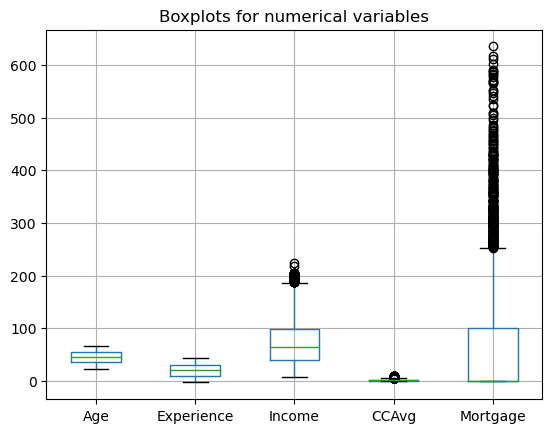

In [23]:
boxplot = numericals.boxplot(column=['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage'])  
boxplot.set_title ('Boxplots for numerical variables')

We observe that there is a greater variability for Mortgage and Income variables as well as larger outliers.

Now we plot histogram for numerical variables with respect to the dependent variable (Personal loan):

Text(0, 0.5, 'Personal Loan')

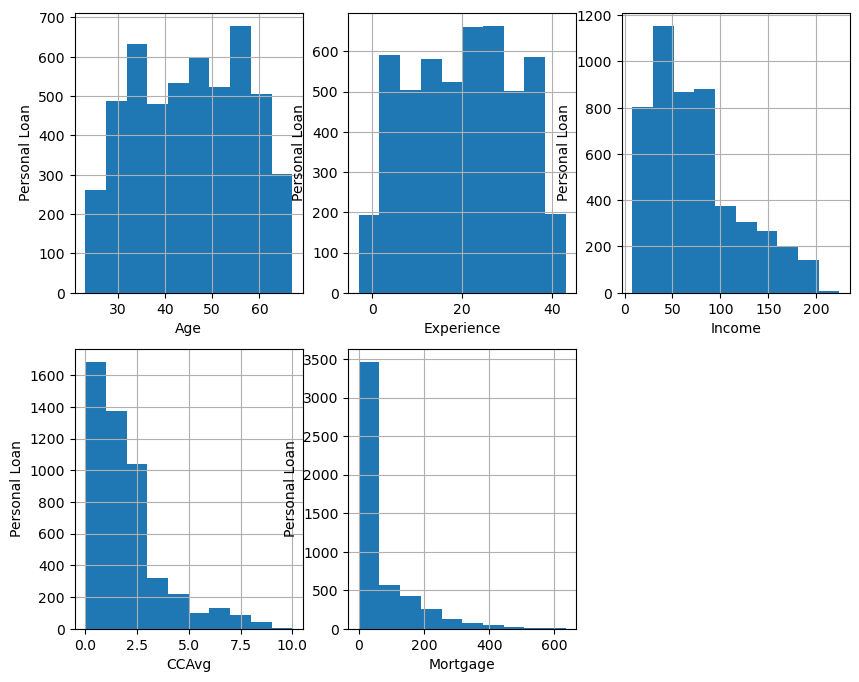

In [24]:
plt. figure (figsize=(10,8))

plt. subplot (2,3,1)
ax=numericals.Age.hist (bins=10)
ax.set_xlabel ('Age')
ax.set_ylabel ('Personal Loan')

plt. subplot (2,3,2)
ax=numericals.Experience.hist (bins=10)
ax.set_xlabel ('Experience')
ax.set_ylabel ('Personal Loan')

plt. subplot (2,3,3)
ax=numericals.Income.hist (bins=10)
ax.set_xlabel ('Income')
ax.set_ylabel ('Personal Loan')

plt. subplot (2,3,4)
ax=numericals.CCAvg.hist (bins=10)
ax.set_xlabel ('CCAvg')
ax.set_ylabel ('Personal Loan')

plt. subplot (2,3,5)
ax=numericals.Mortgage.hist (bins=10)
ax.set_xlabel ('Mortgage')
ax.set_ylabel ('Personal Loan')

As can be seen, the variables of Age and Experience are more symmetrical than the other three variables, and the three variables of Income, CCAvg and Mortgage have more skewness.

Checking **Outliers** for Mortgage variable:

In [25]:
IQR=df_merge.Mortgage.quantile (0.75)-df_merge.Mortgage.quantile (0.25)
Mlower_bound=df_merge.Mortgage.quantile (0.25)-(IQR*3)
Mupper_bound=df_merge.Mortgage.quantile (0.75)+(IQR*3)
(Mlower_bound, Mupper_bound)

(-303.0, 404.0)

The maximum value for the mortgage variable is 635, so there are some outliers for this variable. But here we do not remove the outliers and continue with the same situation.